In [1]:
%matplotlib inline

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import vaex
import pandas as pd
import dask
import dask.dataframe as dd
import numpy as np
import multiprocessing
from tqdm import tqdm
import time

In [3]:
n = 10**6
s = np.arange(n).astype(str)
vx_df = vaex.from_arrays(s=s)

In [4]:
file = './data/test10_6.hdf5'
vx_df.export(file, progress=True, shuffle=True)

[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
  

In [5]:
vx_df = vaex.open(file)
vx_df.executor.buffer_size = len(vx_df) // (multiprocessing.cpu_count() * 2)
pd_df = vx_df.to_pandas_df()
dd_df = dd.from_pandas(pd_df, npartitions=4)

In [6]:
def timeit(expr, n, scope):
    times = []
    for i in range(n):
        s = time.time()
        eval(expr, scope)
        e = time.time()
        times.append(e - s)

    return times

In [7]:
methods = {
	'capitalize': 'df.s.str.capitalize()',
	'cat': 'df.s.str.cat(df.s)',
	'contains': 'df.s.str.contains("9", regex=False)',
	'contains(regex)': 'df.s.str.contains("9", regex=True)',
	'count': 'df.s.str.count("9")',
	'endswith': 'df.s.str.endswith("9")',
	'find': 'df.s.str.find("4")',
	'get': 'df.s.str.get(1)',
	'split+:join': 'df.s.str.split(".").str.join("-")',
	'len': 'df.s.str.len()',
	'ljust': 'df.s.str.ljust(10)',
	'lower': 'df.s.str.lower()',
	'lstrip': 'df.s.str.lstrip("9")',
	'match': 'df.s.str.match("1.*")',
	'pad': 'df.s.str.pad(10)',
	'repeat': 'df.s.str.repeat(2)',
	'replace(:default)': 'df.s.str.replace("123", "321")',
	'replace(:no regex)': 'df.s.str.replace("123", "321", regex=False)',
	'replace(:regex)': 'df.s.str.replace("1?[45]4", "1004", regex=True)',
	'rfind': 'df.s.str.rfind("4")',
	'rjust': 'df.s.str.rjust(10)',
	'rstrip': 'df.s.str.rstrip("9")',
	'slice': 'df.s.str.slice(1, 3)',
	'split': 'df.s.str.split(".")',
	'startswith': 'df.s.str.startswith("9")',
	'strip': 'df.s.str.strip("0")',
	'title': 'df.s.str.title()',
	'upper': 'df.s.str.upper()',
	'zfill': 'df.s.str.zfill(10)'
}

In [8]:
n = 10

performances = {}
for name, expr in tqdm(methods.items()):
    # daskはcompute()で評価
    dask_expr = expr + ".compute()"
    
    # nop() はevaluateして結果を捨てるベンチマーク用のメソッド
    vaex_expr = expr + ".nop()" 

    t_pd = timeit(expr, n, scope={'df': pd_df})
    t_dd = timeit(dask_expr, n, scope={'df': dd_df})
    t_vx = timeit(vaex_expr, n, scope={'df': vx_df})
    
    performance = {
        'pandas': t_pd,
        'dask': t_dd,
        'vaex': t_vx
    }
    print(performance)
    performances[name] = performance

  3%|▎         | 1/29 [00:05<02:23,  5.13s/it]

{'pandas': [0.23754072189331055, 0.23757386207580566, 0.23456978797912598, 0.23557615280151367, 0.23497271537780762, 0.23252487182617188, 0.23420047760009766, 0.23327112197875977, 0.2336292266845703, 0.23293089866638184], 'dask': [0.26166677474975586, 0.2770652770996094, 0.25713634490966797, 0.2524750232696533, 0.2533888816833496, 0.2740590572357178, 0.2517845630645752, 0.2502098083496094, 0.25757908821105957, 0.25270676612854004], 'vaex': [0.018521547317504883, 0.015435457229614258, 0.015863895416259766, 0.015134096145629883, 0.014255285263061523, 0.014773130416870117, 0.01487588882446289, 0.06158804893493652, 0.01260066032409668, 0.013814687728881836]}


  7%|▋         | 2/29 [00:08<02:05,  4.65s/it]

{'pandas': [0.16589951515197754, 0.15716314315795898, 0.15595126152038574, 0.15562009811401367, 0.15552282333374023, 0.1558539867401123, 0.1562037467956543, 0.15598702430725098, 0.15606927871704102, 0.15586566925048828], 'dask': [0.17980408668518066, 0.17970061302185059, 0.18105244636535645, 0.20041680335998535, 0.19891047477722168, 0.1813032627105713, 0.18103957176208496, 0.17346954345703125, 0.1778726577758789, 0.17235994338989258], 'vaex': [0.0153961181640625, 0.014577388763427734, 0.014287948608398438, 0.01452326774597168, 0.01452183723449707, 0.014184713363647461, 0.013518333435058594, 0.011519908905029297, 0.014095783233642578, 0.013451814651489258]}


 10%|█         | 3/29 [00:11<01:46,  4.09s/it]

{'pandas': [0.12362480163574219, 0.1224069595336914, 0.12136507034301758, 0.12141108512878418, 0.12168073654174805, 0.12142372131347656, 0.12146973609924316, 0.12141299247741699, 0.1214141845703125, 0.12174797058105469], 'dask': [0.16015291213989258, 0.1325695514678955, 0.13300347328186035, 0.13011527061462402, 0.16146206855773926, 0.13106417655944824, 0.1322941780090332, 0.13304710388183594, 0.16328787803649902, 0.13206005096435547], 'vaex': [0.015565872192382812, 0.015366077423095703, 0.014636754989624023, 0.01499176025390625, 0.014354467391967773, 0.014417886734008789, 0.01472020149230957, 0.014801263809204102, 0.015079259872436523, 0.013710737228393555]}


 14%|█▍        | 4/29 [00:17<01:59,  4.78s/it]

{'pandas': [0.29967689514160156, 0.2961115837097168, 0.29679417610168457, 0.29822850227355957, 0.29618096351623535, 0.29584240913391113, 0.29671549797058105, 0.29604625701904297, 0.29602932929992676, 0.29620790481567383], 'dask': [0.32284116744995117, 0.32119226455688477, 0.3120613098144531, 0.31298208236694336, 0.3525681495666504, 0.310213565826416, 0.3105354309082031, 0.3452017307281494, 0.31041860580444336, 0.34761595726013184], 'vaex': [0.016236543655395508, 0.017084598541259766, 0.01639842987060547, 0.015545129776000977, 0.01587510108947754, 0.01654338836669922, 0.015741348266601562, 0.015845060348510742, 0.015841245651245117, 0.015440940856933594]}


 17%|█▋        | 5/29 [00:27<02:26,  6.12s/it]

{'pandas': [0.45806026458740234, 0.45587754249572754, 0.45689940452575684, 0.45245790481567383, 0.4539144039154053, 0.4548370838165283, 0.45528149604797363, 0.454251766204834, 0.453458309173584, 0.5043268203735352], 'dask': [0.45209288597106934, 0.48490476608276367, 0.4474925994873047, 0.4460420608520508, 0.4467906951904297, 0.44542837142944336, 0.4424269199371338, 0.44617772102355957, 0.44466519355773926, 0.4448544979095459], 'vaex': [0.014833927154541016, 0.016207218170166016, 0.012931585311889648, 0.015929222106933594, 0.015840768814086914, 0.012587785720825195, 0.014963150024414062, 0.016065359115600586, 0.014819860458374023, 0.014316082000732422]}


 21%|██        | 6/29 [00:31<02:07,  5.52s/it]

{'pandas': [0.19647908210754395, 0.19328856468200684, 0.19240021705627441, 0.1930980682373047, 0.193023681640625, 0.1929917335510254, 0.1928567886352539, 0.19255852699279785, 0.1927623748779297, 0.1924455165863037], 'dask': [0.2051403522491455, 0.2041318416595459, 0.2046046257019043, 0.2036590576171875, 0.2040119171142578, 0.2049088478088379, 0.20435285568237305, 0.20370936393737793, 0.20376205444335938, 0.2037372589111328], 'vaex': [0.015484809875488281, 0.015451908111572266, 0.01580643653869629, 0.015918254852294922, 0.01736927032470703, 0.015916109085083008, 0.01686716079711914, 0.013947486877441406, 0.015469074249267578, 0.017087697982788086]}


 24%|██▍       | 7/29 [00:39<02:20,  6.37s/it]

{'pandas': [0.3995707035064697, 0.3982717990875244, 0.4230313301086426, 0.42267537117004395, 0.39797472953796387, 0.42342495918273926, 0.3980729579925537, 0.4249567985534668, 0.39919042587280273, 0.39909815788269043], 'dask': [0.4140744209289551, 0.4119095802307129, 0.4147963523864746, 0.4106581211090088, 0.40929698944091797, 0.40650248527526855, 0.4104020595550537, 0.41190266609191895, 0.4084653854370117, 0.4111509323120117], 'vaex': [0.014264106750488281, 0.014272451400756836, 0.01512598991394043, 0.012842655181884766, 0.013678312301635742, 0.014575719833374023, 0.014535188674926758, 0.014313220977783203, 0.014893531799316406, 0.011833667755126953]}


 28%|██▊       | 8/29 [00:46<02:20,  6.67s/it]

{'pandas': [0.34887242317199707, 0.3444790840148926, 0.34377479553222656, 0.3438529968261719, 0.34392333030700684, 0.34403347969055176, 0.3436312675476074, 0.34384608268737793, 0.3441464900970459, 0.3437504768371582], 'dask': [0.36347341537475586, 0.3950653076171875, 0.3685123920440674, 0.3680288791656494, 0.37008237838745117, 0.4050936698913574, 0.36820483207702637, 0.4026923179626465, 0.36708760261535645, 0.38985371589660645], 'vaex': [0.01478123664855957, 0.01432490348815918, 0.01409006118774414, 0.013551473617553711, 0.012740850448608398, 0.013486623764038086, 0.012850284576416016, 0.013789176940917969, 0.013605594635009766, 0.011529207229614258]}


 31%|███       | 9/29 [01:05<03:26, 10.33s/it]

{'pandas': [0.9050469398498535, 0.9415905475616455, 0.94923996925354, 0.963071346282959, 0.9206621646881104, 0.898789644241333, 0.9711675643920898, 0.9183003902435303, 0.9048426151275635, 0.9690611362457275], 'dask': [0.9562842845916748, 0.968686580657959, 0.8205585479736328, 1.0196869373321533, 0.9320383071899414, 0.9643430709838867, 0.8988339900970459, 0.8550405502319336, 0.9243307113647461, 0.9625790119171143], 'vaex': [0.03062272071838379, 0.020976781845092773, 0.02150440216064453, 0.0215299129486084, 0.020987510681152344, 0.021146059036254883, 0.021622419357299805, 0.021018266677856445, 0.021901845932006836, 0.019972801208496094]}


 34%|███▍      | 10/29 [01:10<02:42,  8.53s/it]

{'pandas': [0.2005472183227539, 0.2015225887298584, 0.2007579803466797, 0.200608491897583, 0.20073533058166504, 0.20278310775756836, 0.3095672130584717, 0.3679356575012207, 0.20289945602416992, 0.20240521430969238], 'dask': [0.1953275203704834, 0.1907503604888916, 0.19089150428771973, 0.19304203987121582, 0.18948030471801758, 0.1906449794769287, 0.1903228759765625, 0.1905667781829834, 0.1902766227722168, 0.18966937065124512], 'vaex': [0.016020536422729492, 0.012509822845458984, 0.015295743942260742, 0.015238523483276367, 0.011648416519165039, 0.015475034713745117, 0.013318777084350586, 0.014784574508666992, 0.011848926544189453, 0.016263961791992188]}


 38%|███▊      | 11/29 [01:15<02:17,  7.61s/it]

{'pandas': [0.25229454040527344, 0.2484445571899414, 0.24918341636657715, 0.24907946586608887, 0.249556303024292, 0.2500324249267578, 0.25002527236938477, 0.2508573532104492, 0.24852347373962402, 0.2475888729095459], 'dask': [0.2739114761352539, 0.2726726531982422, 0.2742002010345459, 0.2737302780151367, 0.27364277839660645, 0.2745399475097656, 0.27291250228881836, 0.32912683486938477, 0.27570033073425293, 0.27461767196655273], 'vaex': [0.018851518630981445, 0.01603388786315918, 0.01764702796936035, 0.017298460006713867, 0.0160677433013916, 0.016856908798217773, 0.016664981842041016, 0.018075227737426758, 0.016917943954467773, 0.016631603240966797]}


 41%|████▏     | 12/29 [01:19<01:50,  6.50s/it]

{'pandas': [0.1759166717529297, 0.17685317993164062, 0.17511773109436035, 0.17609000205993652, 0.17552852630615234, 0.1743171215057373, 0.17342925071716309, 0.17325448989868164, 0.1727440357208252, 0.17321443557739258], 'dask': [0.19676494598388672, 0.1958472728729248, 0.19494938850402832, 0.19555258750915527, 0.23759222030639648, 0.19640183448791504, 0.19578051567077637, 0.1959974765777588, 0.1950511932373047, 0.19864964485168457], 'vaex': [0.015640735626220703, 0.015628576278686523, 0.014649391174316406, 0.014650106430053711, 0.01562643051147461, 0.014078855514526367, 0.015341520309448242, 0.014141321182250977, 0.014321565628051758, 0.014260053634643555]}


 45%|████▍     | 13/29 [01:23<01:30,  5.67s/it]

{'pandas': [0.16602540016174316, 0.1665184497833252, 0.1650705337524414, 0.1655271053314209, 0.1654367446899414, 0.16532683372497559, 0.16464495658874512, 0.16704082489013672, 0.1654958724975586, 0.1663801670074463], 'dask': [0.18807172775268555, 0.18911290168762207, 0.18981504440307617, 0.18956780433654785, 0.1902308464050293, 0.18927454948425293, 0.18810319900512695, 0.1882610321044922, 0.18864178657531738, 0.1981828212738037], 'vaex': [0.018749475479125977, 0.016577482223510742, 0.016566038131713867, 0.01603221893310547, 0.015188217163085938, 0.016536235809326172, 0.016794443130493164, 0.015586137771606445, 0.017064571380615234, 0.01601409912109375]}


 48%|████▊     | 14/29 [01:30<01:34,  6.29s/it]

{'pandas': [0.3536796569824219, 0.3504188060760498, 0.35239434242248535, 0.34962916374206543, 0.36324095726013184, 0.36738133430480957, 0.36775803565979004, 0.36577773094177246, 0.35302066802978516, 0.3681797981262207], 'dask': [0.3887462615966797, 0.3884739875793457, 0.39023613929748535, 0.40216898918151855, 0.4409794807434082, 0.38725805282592773, 0.38942837715148926, 0.38192296028137207, 0.39401984214782715, 0.4324173927307129], 'vaex': [0.01774311065673828, 0.016045093536376953, 0.015630245208740234, 0.01684260368347168, 0.015101194381713867, 0.016051292419433594, 0.015291929244995117, 0.014619827270507812, 0.014545202255249023, 0.015322685241699219]}


 52%|█████▏    | 15/29 [01:36<01:24,  6.03s/it]

{'pandas': [0.25238490104675293, 0.2513244152069092, 0.25019335746765137, 0.2506282329559326, 0.2508656978607178, 0.25022006034851074, 0.24866557121276855, 0.2496345043182373, 0.24715614318847656, 0.24817919731140137], 'dask': [0.28958940505981445, 0.2757425308227539, 0.27299070358276367, 0.2721548080444336, 0.27064061164855957, 0.27240681648254395, 0.26973414421081543, 0.27311277389526367, 0.27043676376342773, 0.27509236335754395], 'vaex': [0.018143415451049805, 0.017254352569580078, 0.01682281494140625, 0.016608476638793945, 0.017822742462158203, 0.017020225524902344, 0.01728534698486328, 0.017430543899536133, 0.016785860061645508, 0.015081405639648438]}


 55%|█████▌    | 16/29 [01:54<02:06,  9.76s/it]

{'pandas': [0.8730051517486572, 0.8741781711578369, 0.8753254413604736, 0.8744652271270752, 0.8929417133331299, 0.9635481834411621, 0.9596419334411621, 0.8836758136749268, 0.8828029632568359, 0.9091355800628662], 'dask': [0.9249973297119141, 0.9259512424468994, 0.9192337989807129, 0.9702918529510498, 0.9725077152252197, 0.9165189266204834, 0.9189813137054443, 0.9188241958618164, 0.9198896884918213, 0.9298667907714844], 'vaex': [0.017848968505859375, 0.01601862907409668, 0.016835451126098633, 0.01622462272644043, 0.016953229904174805, 0.017108917236328125, 0.015319585800170898, 0.016715288162231445, 0.016733169555664062, 0.016144514083862305]}


 59%|█████▊    | 17/29 [02:02<01:49,  9.09s/it]

{'pandas': [0.35346293449401855, 0.3534708023071289, 0.3539912700653076, 0.3550539016723633, 0.35089802742004395, 0.35134363174438477, 0.3551361560821533, 0.358349084854126, 0.3563711643218994, 0.3519861698150635], 'dask': [0.40435028076171875, 0.37772107124328613, 0.37906813621520996, 0.38013291358947754, 0.38289451599121094, 0.3796396255493164, 0.3915550708770752, 0.37520933151245117, 0.37580060958862305, 0.37333106994628906], 'vaex': [0.01636028289794922, 0.01686859130859375, 0.0156097412109375, 0.01715993881225586, 0.01551198959350586, 0.016620397567749023, 0.016311168670654297, 0.015879392623901367, 0.01604008674621582, 0.017044782638549805]}


 62%|██████▏   | 18/29 [02:07<01:26,  7.82s/it]

{'pandas': [0.2223048210144043, 0.22078609466552734, 0.22047114372253418, 0.22038626670837402, 0.22014164924621582, 0.2204134464263916, 0.22014379501342773, 0.22013068199157715, 0.22027850151062012, 0.22204017639160156], 'dask': [0.24530506134033203, 0.24348998069763184, 0.24427437782287598, 0.2438831329345703, 0.24490094184875488, 0.2437887191772461, 0.24400973320007324, 0.24487662315368652, 0.26505613327026367, 0.2670571804046631], 'vaex': [0.01738142967224121, 0.0171358585357666, 0.01708078384399414, 0.01674962043762207, 0.01688838005065918, 0.016530275344848633, 0.016508102416992188, 0.01673269271850586, 0.01582622528076172, 0.017537355422973633]}


 66%|██████▌   | 19/29 [02:20<01:35,  9.59s/it]

{'pandas': [0.6551740169525146, 0.6474044322967529, 0.6484079360961914, 0.6484646797180176, 0.6452603340148926, 0.6454124450683594, 0.6469542980194092, 0.6477599143981934, 0.6583898067474365, 0.643334150314331], 'dask': [0.7027127742767334, 0.7044081687927246, 0.7039146423339844, 0.6933917999267578, 0.6957798004150391, 0.6974828243255615, 0.6993002891540527, 0.6920652389526367, 0.7017431259155273, 0.7015583515167236], 'vaex': [0.02170872688293457, 0.02187800407409668, 0.022519826889038086, 0.02365708351135254, 0.023003816604614258, 0.022138118743896484, 0.02162480354309082, 0.021871089935302734, 0.022154808044433594, 0.02181863784790039]}


 69%|██████▉   | 20/29 [02:29<01:24,  9.35s/it]

{'pandas': [0.43298888206481934, 0.4458944797515869, 0.4241321086883545, 0.4419093132019043, 0.4403049945831299, 0.4440348148345947, 0.44199562072753906, 0.44413185119628906, 0.44582366943359375, 0.41344618797302246], 'dask': [0.42647600173950195, 0.4317007064819336, 0.4251425266265869, 0.42746925354003906, 0.4273386001586914, 0.4296839237213135, 0.42102599143981934, 0.4271843433380127, 0.4258382320404053, 0.42806243896484375], 'vaex': [0.015112638473510742, 0.01318359375, 0.013194084167480469, 0.015583276748657227, 0.014395952224731445, 0.014322280883789062, 0.015844345092773438, 0.014467954635620117, 0.013401985168457031, 0.014634847640991211]}


 72%|███████▏  | 21/29 [02:35<01:05,  8.18s/it]

{'pandas': [0.2524592876434326, 0.24724149703979492, 0.24628615379333496, 0.2482757568359375, 0.24724960327148438, 0.24643206596374512, 0.246046781539917, 0.24804425239562988, 0.24664878845214844, 0.24642539024353027], 'dask': [0.27571988105773926, 0.27540040016174316, 0.2758193016052246, 0.28090548515319824, 0.27762317657470703, 0.28215861320495605, 0.27376270294189453, 0.27748799324035645, 0.2803356647491455, 0.3109874725341797], 'vaex': [0.01840496063232422, 0.016092538833618164, 0.01821756362915039, 0.018067598342895508, 0.017551660537719727, 0.017226457595825195, 0.01764369010925293, 0.018149375915527344, 0.0177156925201416, 0.017175912857055664]}


 76%|███████▌  | 22/29 [02:38<00:47,  6.86s/it]

{'pandas': [0.16822433471679688, 0.16810846328735352, 0.1665055751800537, 0.16769146919250488, 0.1658778190612793, 0.16822385787963867, 0.1665339469909668, 0.16724729537963867, 0.16650152206420898, 0.1678919792175293], 'dask': [0.18972420692443848, 0.19179224967956543, 0.1893777847290039, 0.1921987533569336, 0.19167184829711914, 0.19016575813293457, 0.18795061111450195, 0.19017577171325684, 0.1906428337097168, 0.20302939414978027], 'vaex': [0.01806497573852539, 0.016416072845458984, 0.016503334045410156, 0.017713546752929688, 0.01589202880859375, 0.017911911010742188, 0.017618894577026367, 0.017216920852661133, 0.01764655113220215, 0.01559305191040039]}


 79%|███████▉  | 23/29 [02:43<00:36,  6.06s/it]

{'pandas': [0.19742059707641602, 0.18828415870666504, 0.18313360214233398, 0.18440032005310059, 0.18278884887695312, 0.23692631721496582, 0.18543505668640137, 0.18708133697509766, 0.18602228164672852, 0.20346307754516602], 'dask': [0.2198798656463623, 0.22058463096618652, 0.20698928833007812, 0.20722222328186035, 0.2095777988433838, 0.20868611335754395, 0.21152710914611816, 0.20709967613220215, 0.20714163780212402, 0.2097625732421875], 'vaex': [0.015594959259033203, 0.015299081802368164, 0.014292240142822266, 0.01398468017578125, 0.015209674835205078, 0.014726400375366211, 0.015564441680908203, 0.014470100402832031, 0.01437067985534668, 0.014483451843261719]}


 83%|████████▎ | 24/29 [03:00<00:47,  9.57s/it]

{'pandas': [0.7733042240142822, 0.9336514472961426, 0.7732911109924316, 0.9819140434265137, 0.8976309299468994, 0.8083579540252686, 0.8569769859313965, 0.8447742462158203, 0.9140877723693848, 0.8513534069061279], 'dask': [0.9559769630432129, 0.9041273593902588, 0.8308236598968506, 0.9533636569976807, 0.8727717399597168, 0.8776383399963379, 0.8593909740447998, 0.9369099140167236, 0.8652260303497314, 0.9089863300323486], 'vaex': [0.01651787757873535, 0.015058040618896484, 0.015770673751831055, 0.015055179595947266, 0.01719832420349121, 0.01607513427734375, 0.014521598815917969, 0.0177154541015625, 0.016334056854248047, 0.015882015228271484]}


 86%|████████▌ | 25/29 [03:05<00:31,  7.96s/it]

{'pandas': [0.19738078117370605, 0.19625020027160645, 0.19663476943969727, 0.19684147834777832, 0.19562959671020508, 0.19540047645568848, 0.1952211856842041, 0.19489717483520508, 0.1948411464691162, 0.19511771202087402], 'dask': [0.20716309547424316, 0.21666383743286133, 0.21763300895690918, 0.20973920822143555, 0.20672059059143066, 0.2073984146118164, 0.20604443550109863, 0.21867060661315918, 0.20605015754699707, 0.2103590965270996], 'vaex': [0.015726089477539062, 0.016110658645629883, 0.015895605087280273, 0.015423059463500977, 0.017589330673217773, 0.014935493469238281, 0.017215728759765625, 0.014545917510986328, 0.015383481979370117, 0.015172243118286133]}


 90%|████████▉ | 26/29 [03:08<00:20,  6.72s/it]

{'pandas': [0.1659071445465088, 0.16716289520263672, 0.1652982234954834, 0.16565752029418945, 0.16553926467895508, 0.16553902626037598, 0.16562604904174805, 0.16653037071228027, 0.166184663772583, 0.16561079025268555], 'dask': [0.1978757381439209, 0.19097280502319336, 0.18909621238708496, 0.23063969612121582, 0.18815183639526367, 0.18880963325500488, 0.18734335899353027, 0.1897439956665039, 0.18823504447937012, 0.22887229919433594], 'vaex': [0.016942262649536133, 0.01654529571533203, 0.01627039909362793, 0.016164779663085938, 0.016218185424804688, 0.016988754272460938, 0.015429019927978516, 0.01653289794921875, 0.01613926887512207, 0.014896869659423828]}


 93%|█████████▎| 27/29 [03:14<00:12,  6.23s/it]

{'pandas': [0.23429298400878906, 0.23183369636535645, 0.23162198066711426, 0.23252034187316895, 0.2308359146118164, 0.2327275276184082, 0.2343761920928955, 0.23382163047790527, 0.23194098472595215, 0.23198366165161133], 'dask': [0.25191378593444824, 0.25214385986328125, 0.25150442123413086, 0.26564598083496094, 0.27810144424438477, 0.2713501453399658, 0.2590818405151367, 0.25653624534606934, 0.25765371322631836, 0.2587928771972656], 'vaex': [0.015946626663208008, 0.01596975326538086, 0.01634049415588379, 0.014990806579589844, 0.016431093215942383, 0.015928983688354492, 0.015754222869873047, 0.01646113395690918, 0.015615224838256836, 0.016362667083740234]}


 97%|█████████▋| 28/29 [03:18<00:05,  5.56s/it]

{'pandas': [0.1788179874420166, 0.180405855178833, 0.17880463600158691, 0.17974519729614258, 0.17803502082824707, 0.17841029167175293, 0.1790611743927002, 0.17955946922302246, 0.17792963981628418, 0.17830586433410645], 'dask': [0.19922900199890137, 0.20151877403259277, 0.1990950107574463, 0.21699047088623047, 0.2142162322998047, 0.20762848854064941, 0.20096683502197266, 0.22399115562438965, 0.20094060897827148, 0.1980581283569336], 'vaex': [0.016125917434692383, 0.015583276748657227, 0.01834893226623535, 0.014435529708862305, 0.013469696044921875, 0.013845443725585938, 0.01219940185546875, 0.010689496994018555, 0.011218070983886719, 0.010870933532714844]}


100%|██████████| 29/29 [03:23<00:00,  5.49s/it]

{'pandas': [0.2532498836517334, 0.24697017669677734, 0.24425625801086426, 0.2445673942565918, 0.24313807487487793, 0.24417781829833984, 0.24326395988464355, 0.24434161186218262, 0.2431797981262207, 0.2473294734954834], 'dask': [0.2748143672943115, 0.2717251777648926, 0.2689228057861328, 0.270521879196167, 0.26891279220581055, 0.27008605003356934, 0.2687830924987793, 0.2691648006439209, 0.2700493335723877, 0.27423572540283203], 'vaex': [0.016138076782226562, 0.016790151596069336, 0.01749110221862793, 0.017863988876342773, 0.017812013626098633, 0.01706695556640625, 0.0168912410736084, 0.017198562622070312, 0.015867948532104492, 0.017626047134399414]}


In [22]:
dfs = []
for name, p in performances.items():
    tmp_df = pd.DataFrame(performances['split']).stack()
    tmp_df = tmp_df.reset_index()
    tmp_df = tmp_df.rename(columns={"level_0": "n", "level_1": "type", 0: "time"})
    tmp_df['method'] = name
    dfs.append(tmp_df)

In [23]:
dfp = pd.concat(dfs)

In [27]:
import seaborn as sns

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns

In [34]:
sns.set(style="ticks", palette="pastel")

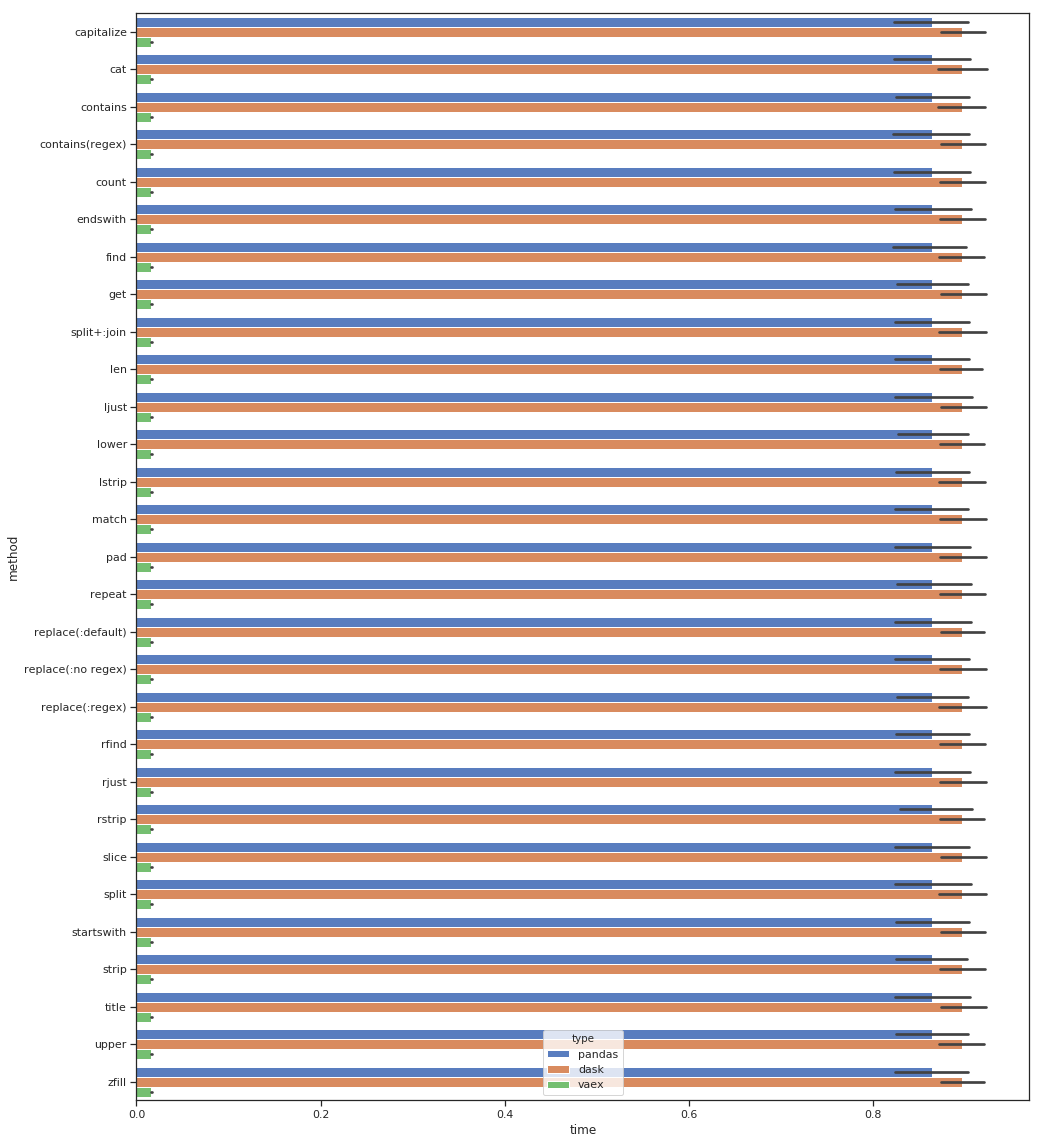

In [40]:
plt.figure(figsize=(16, 20))
ax = sns.barplot(
    data=dfp, y="method", x="time", hue="type", palette="muted"
)

In [43]:
dfp.groupby(['type', 'method'])['time'].mean()

type    method            
dask    capitalize            0.896521
        cat                   0.896521
        contains              0.896521
        contains(regex)       0.896521
        count                 0.896521
        endswith              0.896521
        find                  0.896521
        get                   0.896521
        len                   0.896521
        ljust                 0.896521
        lower                 0.896521
        lstrip                0.896521
        match                 0.896521
        pad                   0.896521
        repeat                0.896521
        replace(:default)     0.896521
        replace(:no regex)    0.896521
        replace(:regex)       0.896521
        rfind                 0.896521
        rjust                 0.896521
        rstrip                0.896521
        slice                 0.896521
        split                 0.896521
        split+:join           0.896521
        startswith            0.89652